## EXERCISE 4

We want to study the performances of an RBM, and, by looking at its learned weights and biases, better understand the correlations in the data (from file x_RBM_2024_exercise.dat, N=104 configurations with L=10 bits). Use an RBM with M=3 hidden units.

| Name | Surname | ID Number |
|------|---------|---------------------|
| Lucrezia | Rossi | 2122164 |
| Lorenzo | Calandra Buonaura | 2107761 |
| Andrea | Turci | 2106724 |

In [1]:
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 13

from IPython.display import display_html 
import pandas as pd

In [2]:
dname = "DATA"; fname = dname + '/x_RBM_2024_exercise.dat'

v = np.loadtxt(fname, delimiter = " ", dtype = int)
N = len(v)
L = len(v[1])


print(f'each of N={N} data has L={L} digits')

each of N=10000 data has L=10 digits


In [3]:
class RBM:
    def __init__(self, v, L, M, SPINS = False):
        self.L = L
        self.M = M

        if SPINS:
            self.GAP=2
            self.v = 2 * v - 1
            self.vmin = -1
        else:
            self.GAP=1
            self.vmin = 0
            self.v = v
                    
        self.sigma = np.sqrt(4. / float(L + M))

    def _initialize_weights(self):
        np.random.seed(12345)
        self.w = self.sigma * np.random.randn(self.L, self.M)
        self.a = self.sigma * np.random.randn(self.L)
        self.b = np.zeros(self.M)
        
        self.w0 = np.copy(self.w)
        self.a0 = np.copy(self.a)
        self.b0 = np.copy(self.b)
        
        print("w =", self.w)
        print("a =", self.a)
        print("b =", self.b)
        
    def _energy(self, v, h):
        return -np.dot(v, self.a) - np.dot(h, self.b) - np.sum(np.dot(v, self.w) * h)
    
    def _log_likelihood(self, data):
        possible_configs_v = list(it.product([0, 1], repeat=self.L))
        possible_configs_h = list(it.product([0, 1], repeat=self.M))
        energies = []
        
        for v in data:
            num = np.sum([self._energy(v, h) * np.exp(-self._energy(v, h)) for h in possible_configs_h])
            den = np.sum([np.exp(-self._energy(v, h)) for h in possible_configs_h])
            
            energies.append(num / den)
        
        avg_energy_data = np.mean(energies)
        partition_func = np.sum([np.exp(-self._energy(v,h)) for h in possible_configs_h for v in possible_configs_v])
        
        log_likelihood = - avg_energy_data - np.log(partition_func)
        
        return log_likelihood

    def _activate(self, v_in, wei, bias, DeltaE, info=False):
        
        act = np.dot(v_in, wei) + bias
        n = np.shape(act)
        prob = 1. / (1. + np.exp(-DeltaE*act))
        v_out = np.full(n, self.vmin, dtype=int) # a list on -1's or 0's
        v_out[np.random.random_sample(n) < prob] = 1 # activate the 1's with probability prob
        if info:
            print('input=', v_in)
            print('act=',act)
            print('prob=',prob)
            print('output=',v_out)
        return v_out

    def _compute_cd_steps(self, cd_steps, h_i):
        hf=h_i  #set for the sake of the loop
        for _ in range(cd_steps):
            vf = self._activate(hf,self.w.T,self.a,self.GAP)
            hf = self._activate(vf,self.w,self.b,self.GAP)
        return vf,hf
    
    def _train(self, l_rate=1.0, minibatch_size=500, n_epochs=100, n_steps=5, show_graph = False):
      N = len(self.v)
      np.random.seed(12345)
      np.random.shuffle(self.v)
      m = 0
      self.minibatch_size = minibatch_size
      
      for epoch in range(n_epochs):
        l_rate_epoch = l_rate / self.minibatch_size
        
        for k in range(N):
          if m == 0:
            self._initialize_minibatch()

            h = self._activate(self.v[k], self.w, self.b, self.GAP)
                
            vf, hf = self._compute_cd_steps(n_steps, h)

            self.v_data += self.v[k]
            self.v_model += vf
            self.h_data += h
            self.h_model += hf

            self.vh_data += np.outer(self.v[k].T, h)
            self.vh_model += np.outer(vf.T, hf)

            m += 1

            if m == self.minibatch_size:
              dw = l_rate_epoch * (self.vh_data - self.vh_model)
              da = l_rate_epoch * (self.v_data - self.v_model)
              db = l_rate_epoch * (self.h_data - self.h_model)

              if epoch<=1 and k<= self.minibatch_size:
                print('----------- epoch =',epoch,'  k=',k,'  m=',m)
                print('dw =',dw)
                print('da =',da)
                print('db =',db)
                    
              self.w += dw
              self.a += da
              self.b += db
            
            m = 0
                    
        np.random.shuffle(v)
        l_rate = l_rate / (0.01 * l_rate + 1)
        print(f"Epoch: {epoch}")
        
        if epoch%10 == 9:
          print(f"Epoch: {epoch+1}")
          
          if show_graph == True:
            self._plot_graph(epoch + 1)

    def _initialize_minibatch(self):
        self.v_data = np.zeros(self.L)
        self.v_model = np.zeros(self.L)
        self.h_data = np.zeros(self.M)
        self.h_model = np.zeros(self.M)
        self.vh_data = np.zeros((self.L, self.M))
        self.vh_model = np.zeros((self.L, self.M))

    def _plot_graph(self, epoch=0):
        fig, ax = plt.subplots(1, 1, figsize=(7, 3.3))
        ax.tick_params(left=False, bottom=False)
        ax.xaxis.set_major_formatter(plt.NullFormatter())
        ax.yaxis.set_major_formatter(plt.NullFormatter())

        x1 = [0] * self.L
        y1 = list(range(self.L))
        for i in range(self.L):
            y1[i] = 1 * (y1[i] / (self.L - 1.) - 0.5)
            
        x2 = [1] * self.L
        y2 = list(range(self.L))
        for i in range(self.L):
            y2[i] = 0.7 * (y2[i] / (self.L - 1.) - 0.5)
            
        A = 1. / max(self.w.max(), -self.w.min())
        for i in range(self.L):
            for j in range(self.M):
                ex, ey, col = (y1[i], y2[j]), (x1[i], x2[j]), self._my_color(self.w[i][j])
                ax.plot(ex, ey, col, zorder=1, alpha=A * abs(self.w[i][j]))

        A = 300.
        for i in range(self.L):
            ax.scatter(y1[i], x1[i], s=A * abs(self.a[i]), zorder=2, c=self._my_color(self.a[i]))

        for j in range(self.M):
            ax.scatter(y2[j], x2[j], s=min(300, A * abs(self.b[j])), zorder=2, c=self._my_color(self.b[j]),
                       marker="s")
        ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
        ax.text(-0.51, 0.85, "hidden\nlayer")
        plt.show()
          
    def noise_reduction(self, n_steps):
      N = len(self.v)
      np.random.seed(12345)
      np.random.shuffle(self.v)
      self.m = 0

      ampl=40
      N1=12

      # original, non-reshuffled data in v0
      v1 = np.zeros_like(self.v)
      for k in range(N):
          h = self._activate(self.v[k], self.w, self.b, self.GAP)
          v1[k], hf = self._compute_cd_steps(n_steps, h)

      # difference between fantasy and data
      diff = (v1 - self.v)/2
      str0 = fname+'_M'+str(self.M)+'-mini'+ str(self.minibatch_size)
      np.savetxt(str0+".fantasy", (v1+1)/2, fmt='%d',delimiter=' ')  
      np.savetxt(str0+'.diff', diff, fmt='%d',delimiter=' ')  

      df0 = pd.DataFrame(self.v[:N1])
      df1 = pd.DataFrame(((v1[:N1]- self.vmin)/(1 - self.vmin)).astype(int))

      df0s = df0.style.set_table_attributes("style='display:inline'")
      df1s = df1.style.set_table_attributes("style='display:inline'")
      df0s.map(self.is_one)
      df1s.map(self.is_one)
      sty = [dict(selector="caption",props=[("font-size", "150%")])]
      df0s.set_caption('Original').set_table_styles(sty)
      df1s.set_caption('Denoised').set_table_styles(sty)

      display_html(df0s._repr_html_()+df1s._repr_html_(), raw=True)
      
    @staticmethod
    def _my_color(val):
        if val > 0:
            return 'red'
        elif val < 0:
            return 'blue'
        else:
            return 'black'
          
    @staticmethod
    def is_one(cell_value):
      color0 = 'background-color: gray; color: white'
      color1 = 'background-color: white;'
      if type(cell_value) in [float, int]:
          if cell_value == 1:
              return color1
      return color0

w = [[-1.13551379e-01  2.65669964e-01 -2.88132757e-01]
 [-3.08263709e-01  1.09041887e+00  7.72922489e-01]
 [ 5.15360175e-02  1.56284646e-01  4.26576969e-01]
 [ 6.91397593e-01  5.58688134e-01 -7.19014104e-01]
 [ 1.52537913e-01  1.26978019e-01  7.50463234e-01]
 [ 4.91702529e-01 -1.11030861e+00 -2.06261128e-01]
 [ 9.25808667e-01 -2.43274719e-01 -2.99394686e-01]
 [ 2.64583679e-01  1.80218983e+00 -5.66475108e-01]
 [-3.20110440e-01  6.88500960e-02  1.67859802e-01]
 [ 2.90536469e-01  5.21572266e-04  7.45411556e-01]]
a = [-0.39580299 -0.46104103 -1.31476796 -1.03216437 -0.4774623   0.3107127
 -0.70221411  0.06646813 -0.58993056  0.18465011]
b = [0. 0. 0.]


Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9


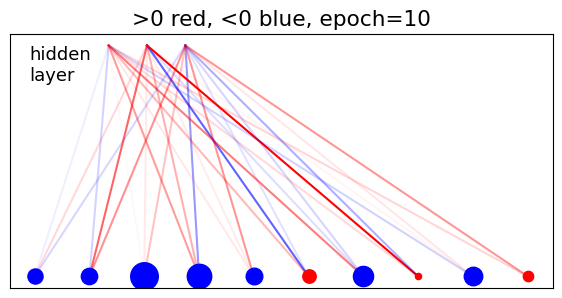

Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19


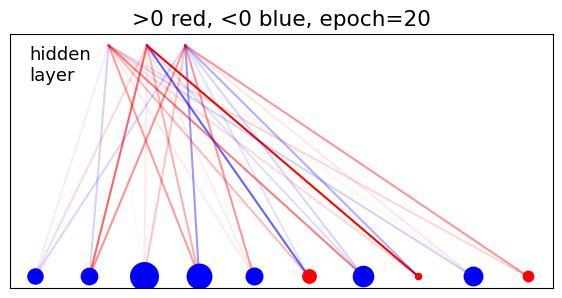

Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29


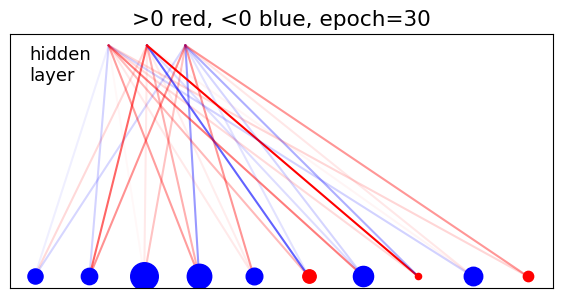

Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39


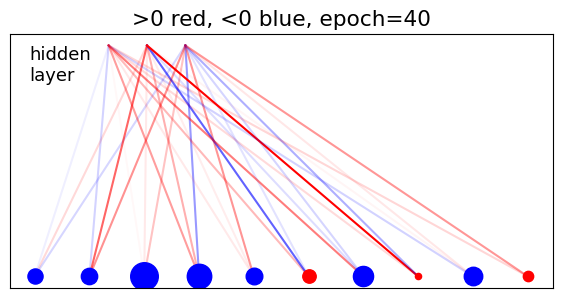

Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49


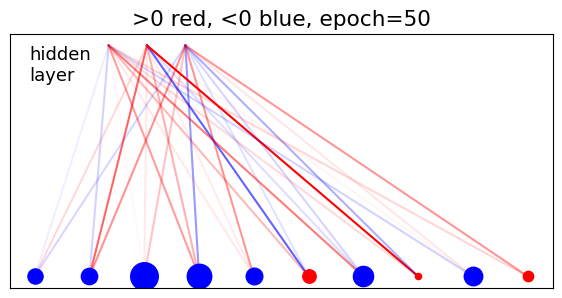

Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59


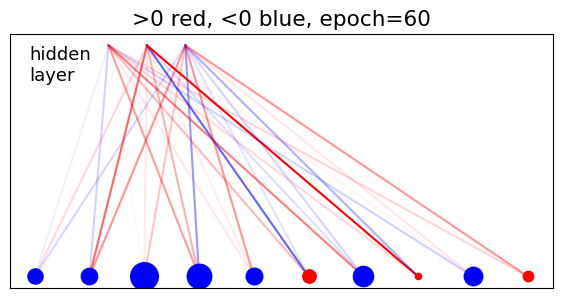

Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69


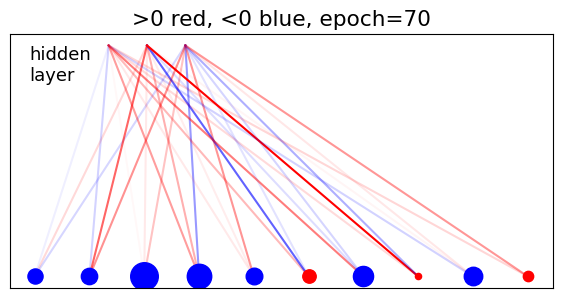

Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79


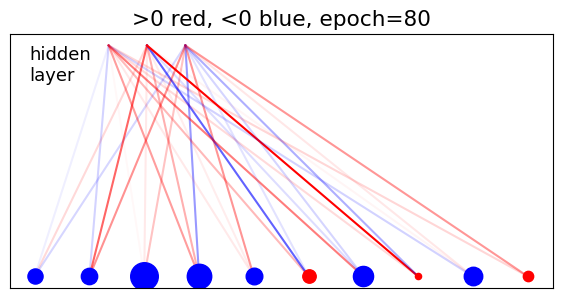

Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89


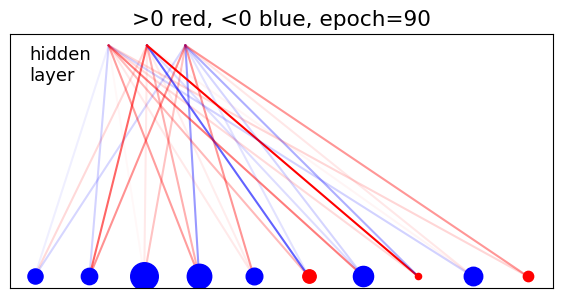

Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99


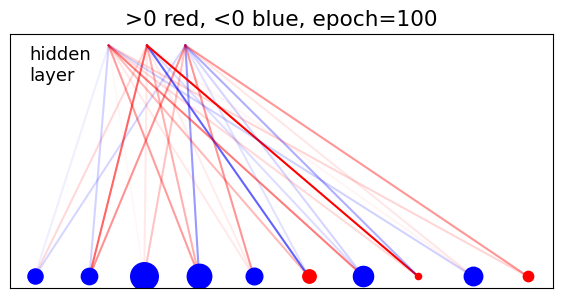

In [4]:
M=3

rbm = RBM(v, L, M)
rbm._initialize_weights()
rbm._train(show_graph=True)

In [5]:
rbm.noise_reduction(5)

,0,1,2,3,4,5,6,7,8,9
0,1,0,0,1,0,1,0,1,1,0
1,0,1,0,1,1,1,1,0,1,0
2,0,1,0,1,0,1,1,0,0,0
3,1,1,0,0,0,1,0,1,0,0
4,0,0,1,1,0,1,0,1,0,0
5,1,1,0,1,1,0,1,1,1,1
6,1,0,1,0,0,1,1,1,1,0
7,1,1,0,0,1,1,0,0,1,0
8,0,1,1,1,1,0,0,1,1,0
9,1,1,1,0,1,0,0,1,0,1
